In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
import cv2
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Flatten,InputLayer,BatchNormalization,Input,Layer,Dropout,RandomFlip,RandomRotation,Resizing,Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy,BinaryAccuracy,FalseNegatives,FalsePositives,TrueNegatives,TruePositives,Precision,Recall,AUC
import sklearn
import albumentations as A
from albumentations.augmentations import CoarseDropout 
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

C:\Users\adity\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
dataset, dataset_info=tfds.load('malaria',with_info = True,as_supervised=True,shuffle_files=True,split=['train'] )

INFO:absl:Load dataset info from C:\Users\adity\tensorflow_datasets\malaria\1.0.0
INFO:absl:Reusing dataset malaria (C:\Users\adity\tensorflow_datasets\malaria\1.0.0)
INFO:absl:Creating a tf.data.Dataset reading 4 files located in folders: C:\Users\adity\tensorflow_datasets\malaria\1.0.0.
INFO:absl:Constructing tf.data.Dataset malaria for split ['train'], from C:\Users\adity\tensorflow_datasets\malaria\1.0.0


In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\adity\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

In [5]:
def splits(dataset,train_ratio,val_ratio,test_ratio):
    Data_size = len(dataset)
    train_dataset = dataset.take(int(train_ratio*Data_size))
    val_test_dataset = dataset.skip(int(train_ratio*Data_size))
    val_dataset = val_test_dataset.take(int(val_ratio*Data_size))
    test_dataset = val_test_dataset.skip(int(val_ratio*Data_size))
    return train_dataset,val_dataset,test_dataset


In [6]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio =0.1

# dataset = tf.data.Dataset.range(10)
train_dataset,val_dataset,test_dataset = splits(dataset[0],train_ratio,val_ratio,test_ratio)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
     list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## Dataset Visualization

In [7]:
image = next(iter(train_dataset))

Text(0.5, 1.0, "['parasitized', 'uninfected']")

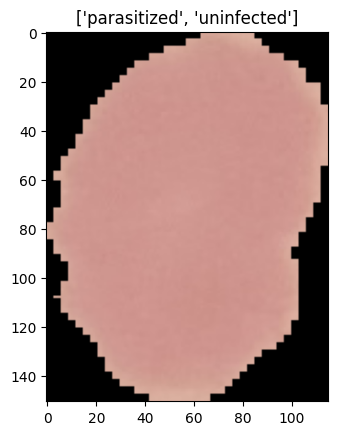

In [8]:
plt.imshow(image[0])
plt.title(dataset_info.features['label'].names)

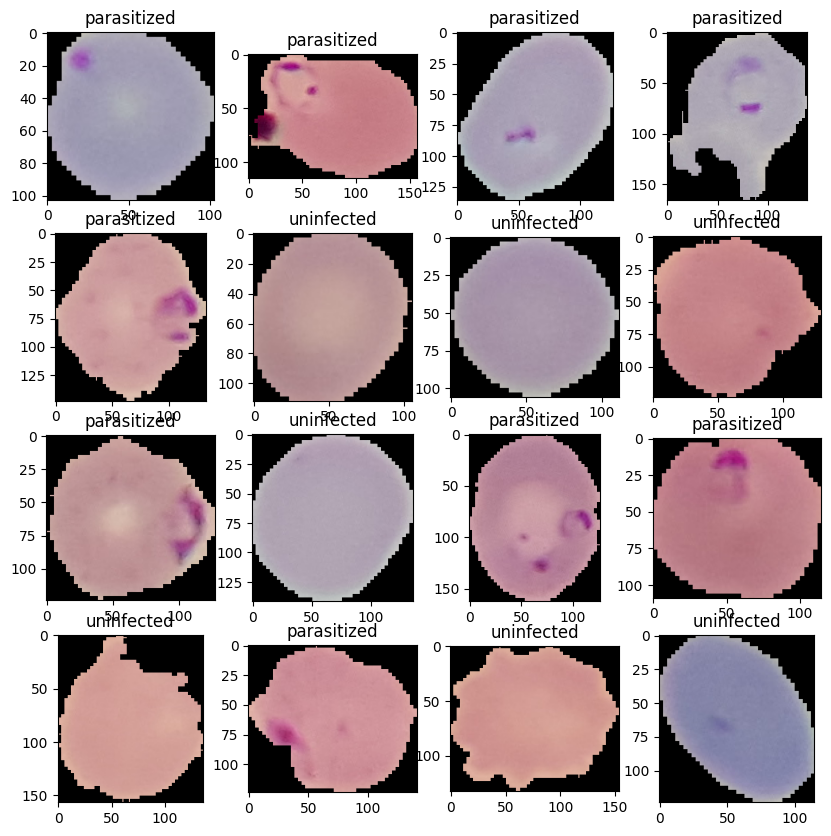

In [9]:
plt.figure(figsize=(10,10))
for i, (image,label)in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    

In [10]:
def visualize(original,augmented):
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.subplot(1,2,2)
    plt.imshow(augmented)
    

In [11]:
original,label=next(iter(train_dataset))

In [12]:
augmented = tf.image.central_crop(original,0.9)

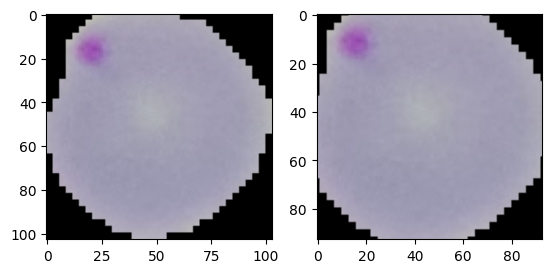

In [13]:
visualize(original,augmented)

In [14]:
IM_size = 224
def resizing_rescale(image,label):
    return tf.image.resize(image,(IM_size, IM_size))/225.0,label

In [15]:
def augment(image,label):
    image,label =resizing_rescale(image,label)
    image = tf.image.rot90(image)
    image = tf.image.adjust_hue(image,delta=0.5)
    image = tf.image.flip_left_right(image)
    
    return image,label

In [16]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25,0.2501)),
    RandomFlip(mode='horizontal',)])
def augment_layer(image,label):
    return augment_layers(image,training =True),label

In [17]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_size,IM_size),
    Rescaling(1.0/225)])
def resize_rescale_layer(image,label):
    return resize_rescale_layers(image,training =True),label

#### Mixup Data Augmentation

In [18]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing_rescale)

mix_dataset = tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [19]:
mix_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [20]:
def mixup(train_dataset_1,train_dataset_2):
    (image_1,label_1),(image_2,label_2) = train_dataset_1,train_dataset_2
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    image = lamda*image_1 + (1-lamda)*image_2
    label = lamda*tf.cast(label_1,dtype = tf.float32) + (1-lamda)*tf.cast(label_2,dtype = tf.float32)
    return image,label

In [21]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

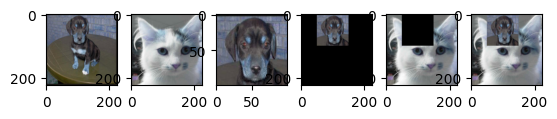

In [22]:
plt.subplot(1,6,1)
image_1 = cv2.resize(cv2.imread('dog.jpg'),(IM_size,IM_size))
plt.imshow(image_1)

plt.subplot(1,6,2)
image_2 = cv2.resize(cv2.imread('cat.jpg'),(IM_size,IM_size))
plt.imshow(image_2)

plt.subplot(1,6,3)
crop = tf.image.crop_to_bounding_box(image_1,0,50,100,100)
plt.imshow(crop)

plt.subplot(1,6,4)
crop_2 = tf.image.pad_to_bounding_box(crop,0,50,IM_size,IM_size)
plt.imshow(crop_2)

plt.subplot(1,6,5)
crop_3 = tf.image.crop_to_bounding_box(image_2,0,50,100,100)
crop_4 = tf.image.pad_to_bounding_box(crop_3,0,50,IM_size,IM_size)
plt.imshow(image_2-crop_4)

plt.subplot(1,6,6)
plt.imshow(image_2-crop_4+crop_2)

In [23]:
def box(lamda):
    
    r_x = tf.cast(tfp.distributions.Uniform(0,IM_size).sample(1)[0],dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0,IM_size).sample(1)[0],dtype = tf.int32)

    r_w = tf.cast(IM_size*tf.math.sqrt(1-lamda),dtype=tf.int32)
    r_h = tf.cast(IM_size*tf.math.sqrt(1-lamda),dtype=tf.int32)

    r_x = tf.clip_by_value(r_x -r_w//2,0,IM_size)
    r_y = tf.clip_by_value(r_y -r_h//2,0,IM_size)

    x_b_r = tf.clip_by_value(r_x +r_w//2,0,IM_size)
    y_b_r = tf.clip_by_value(r_y +r_h//2,0,IM_size)

    r_w = x_b_r - r_x
    if(r_w ==0):
        r_w=1
    r_h = y_b_r - r_y
    if(r_h ==0):
        r_h=1
    return r_x,r_y,r_w,r_h 

In [24]:
def cutmix(train_dataset_1,train_dataset_2):
    (image_1,label_1),(image_2,label_2) = train_dataset_1,train_dataset_2
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    r_x,r_y,r_w,r_h = box(lamda)

    crop_2 = tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
    
    pad_2 = tf.image.pad_to_bounding_box(crop_2,r_y,r_x,IM_size,IM_size)

    crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,IM_size,IM_size)

    image = image_1-pad_1+pad_2  
    lamda = tf.cast(1 -(r_w*r_h)/(IM_size**2),dtype = tf.float32)
    label = lamda*tf.cast(label_1,dtype = tf.float32)+(1-lamda)*tf.cast(label_2,dtype = tf.float32)
    return image,label

In [25]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

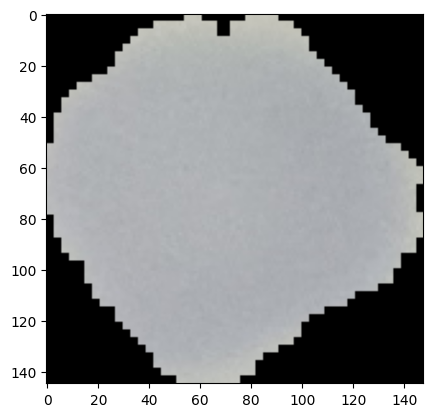

In [26]:
original,_ = next(iter(train_dataset))
plt.imshow(original)

### Albumentations

In [27]:
transforms = A.Compose(
    [
      A.Resize(IM_size, IM_size),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
#       A.Cutout(p=0.5),  
      A.CoarseDropout (max_holes=8, max_height=8, max_width=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5), 
])

In [28]:
def aug_albument(image):
    
    data = {"image":image}
    image = transforms(**data)
    image = image["image"]
    image = tf.cast(image/255., tf.float32)
    return image

In [29]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IM_size, IM_size, 3))
    return aug_img, label

In [30]:
train_dataset =(train_dataset
                .shuffle(buffer_size= 1024 , reshuffle_each_iteration=True)
                .map(process_data)
                .batch(32)
                .prefetch(tf.data.AUTOTUNE))

In [31]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

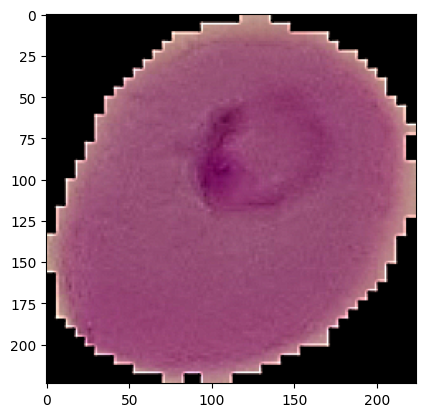

In [32]:
image,_ = next(iter(train_dataset))
plt.imshow(image[0])

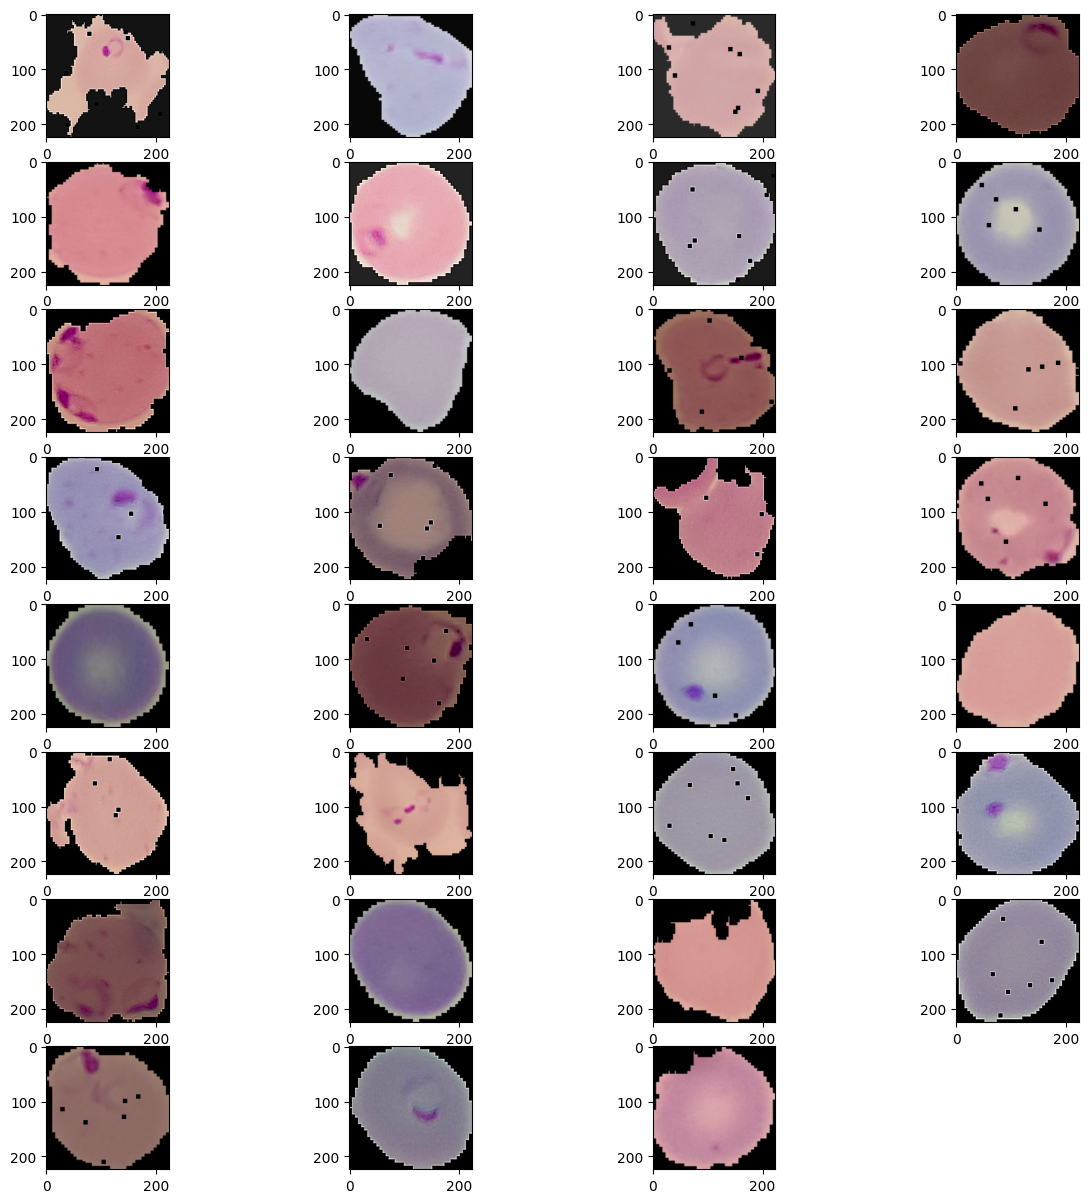

In [33]:
plt.figure(figsize=(15,15))

for i in range(1,32):
    plt.subplot(8,4,i)
    plt.imshow(image[i])

In [34]:
val_dataset = val_dataset.map(resizing_rescale)
val_dataset = val_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
test_dataset = test_dataset.map(resizing_rescale)

In [36]:
rate = 0.3
model = tf.keras.Sequential([InputLayer(shape=(IM_size,IM_size,3)),
                            Conv2D(filters=6,strides=1,kernel_size=3,padding='valid',activation='relu',kernel_regularizer= L2(0.01)),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2),
                            Dropout(rate = rate),
                            Conv2D(filters=16,strides=1,kernel_size=3,padding='valid',activation='relu',kernel_regularizer= L2(0.01)),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2),
                            Flatten(),
                            Dense(100,activation ='relu'),
                            BatchNormalization(),
                            Dropout(rate = rate),
                            Dense(10,activation ='relu'),
                            BatchNormalization(),
                            Dense(1,activation ='sigmoid')])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Callbacks

In [37]:
class LossCallback(Callback):
    def on_epoch_end(self,epoch,logs):
        print('\n Epoch Number{} the model has a loss of {}'.format(epoch+1,logs['loss']))
    def on_batch_end(self,batch,logs):
        print('\n Batch Number{} the model has a loss of {}'.format(batch+1,logs['loss']))
        

#### CSVLogger

In [38]:
csv_callback = CSVLogger('logs.csv',separator=',',append=False)

#### EarlyStopping

In [39]:
es_callback = EarlyStopping(monitor = 'val_loss',min_delta= 0,patience =2,
                            verbose=1,mode='auto',restore_best_weights=True,baseline = None   )

#### Learning rate scheduler

In [40]:
metric_dir = './logs/metrics'
train_writer = tf.summary.create_file_writer(metric_dir)

In [41]:
Dir = './logs'
tb_callback = tf.keras.callbacks.TensorBoard(log_dir= Dir)

In [42]:
def scheduler(epoch,lr):
    if epoch <= 3:
        learning_rate= lr
    else:
        learning_rate= lr *  tf.math.exp(-0.1).numpy()
#     with train_writer.as_default():
#         tf.summary.scalar('Learning Rate',data=learning_rate,step='epoch')
    return learning_rate

In [43]:
lrs_callback = LearningRateScheduler(scheduler,verbose=1)

#### Model Check Point

In [44]:
checkpoint_callback = ModelCheckpoint(
    'Malaria Diagnosis/best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=3,
    initial_value_threshold=None
)

In [45]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### ReduceLROnPlateau 

In [46]:
plateau_callback =ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
)

In [47]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

### Custom Metric

In [48]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self,Factor):
        super(CustomBCE,self).__init__()
        self.Factor = Factor
    def call(self,y_true,y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true,y_pred)*self.Factor

In [49]:
def custom_bce(y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)

### Custom Accuracy

In [50]:
def custom_acc(y_true,y_pred):
    return BinaryAccuracy(y_true,y_pred)

In [51]:
class CustomAccuracy(tf.keras.metrics.Metric):
    
    def __init__(self, name = 'Custom_Accuracy', FACTOR = 1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name = name, initializer = 'zeros')


    def update_state(self, y_true, y_pred, sample_weight = None):
        output = binary_accuracy(tf.cast(y_true, dtype = tf.float32), y_pred)*self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype = tf.float32)/tf.cast(tf.size(output), dtype = tf.float32))

    def result(self):
        return self.accuracy

    def reset_states(self):
        self.accuracy.assign(0.)

In [52]:
tb_callback=tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [53]:
factor = 1
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics=metrics
)


In [54]:
optimiser = Adam(learning_rate=0.01)
epochs = 3
metric = BinaryAccuracy()
metric_val = BinaryAccuracy()

In [55]:
history  =model.fit(train_dataset, validation_data= val_dataset , epochs=2,verbose =1,callbacks=[tb_callback,lrs_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 193s 270ms/step - accuracy: 0.6943 - auc: 0.7600 - fn: 1280.5609 - fp: 1532.0173 - loss: 0.6248 - precision: 0.6863 - recall: 0.7168 - tn: 3992.5347 - tp: 4250.8350 - val_accuracy: 0.4944 - val_auc: 0.8518 - val_fn: 1393.0000 - val_fp: 0.0000e+00 - val_loss: 1.6671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1362.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 190s 276ms/step - accuracy: 0.9175 - auc: 0.9533 - fn: 356.6956 - fp: 537.0087 - loss: 0.3043 - precision: 0.9034 - recall: 0.9357 - tn: 4984.7002 - tp: 5177.5435 - val_accuracy: 0.4958 - val_auc: 0.4970 - val_fn: 1388.0000 - val_fp: 1.0000 - val_loss: 3.3020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1366.0000 - val_tp: 0.0000e+00 - learning_rate: 0.0100


In [56]:
%load_ext tensorboard

In [58]:
tensorboard --logdir './logs'

Reusing TensorBoard on port 6007 (pid 116944), started 0:50:13 ago. (Use '!kill 116944' to kill it.)

In [ ]:
for epoch in range(epochs):
    print(f'{epoch} start')
    for step,(x_batch,y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch,training = True)
            loss = custom_bce(y_batch,y_pred)
        partial = tape.gradient(loss,model.trainable_weights)
        optimiser.apply_gradients(zip(partial,model.trainable_weights))
        metric.update_state(y_batch,y_pred)
    print(f'training loss:{loss}')
    print(f'training accuracy:{metric.result()}')
    metric.reset_state()
    for step,(x_batch_val,y_batch_val) in enumerate(val_dataset):
        y_pred_val = model(x_batch_val,training = False)
        loss = custom_bce(y_batch_val,y_pred_val)
        metric_val.update_state(y_batch_val,y_pred_val)
    print(f'val loss:{loss}')
    print(f'val accuracy:{metric_val.result()}')
    metric_val.reset_state()

In [39]:
test_dataset = test_dataset.batch(1)

In [20]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9353 - auc: 0.9763 - fn: 27.9322 - fp: 61.9351 - loss: 0.1854 - precision: 0.9144 - recall: 0.9620 - tn: 626.2955 - tp: 663.3369


[0.18578404188156128,
 1303.0,
 125.0,
 1268.0,
 61.0,
 0.9325353503227234,
 0.91246497631073,
 0.9552785754203796,
 0.9775627851486206]

In [19]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [20]:
# print(labels)
labels = np.array([i[0] for i in labels])
print(labels)

[0 1 0 ... 0 1 1]


In [21]:
print(np.array(inp).shape)

(5513, 1, 224, 224, 3)


In [22]:
y_pred = model.predict(np.array(inp)[:,0,...])
print(y_pred)

173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step
[[0.01547979]
 [0.9999992 ]
 [0.99813765]
 ...
 [0.24880424]
 [0.99999917]
 [0.9999997 ]]


[[2319  456]
 [ 204 2534]]


Text(0.5, 14.722222222222216, 'predicted')

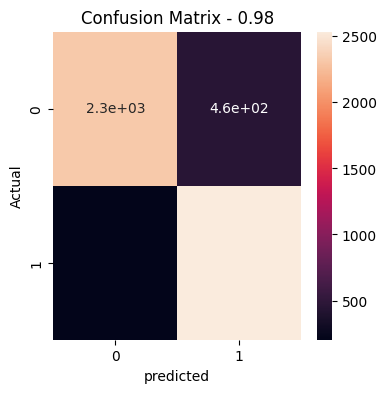

In [26]:
threshold = 0.98
cm = confusion_matrix(labels,y_pred>threshold)
print(cm)
plt.figure(figsize=(4,4))

sns.heatmap(cm,annot=True,)
plt.title(f'Confusion Matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('predicted')

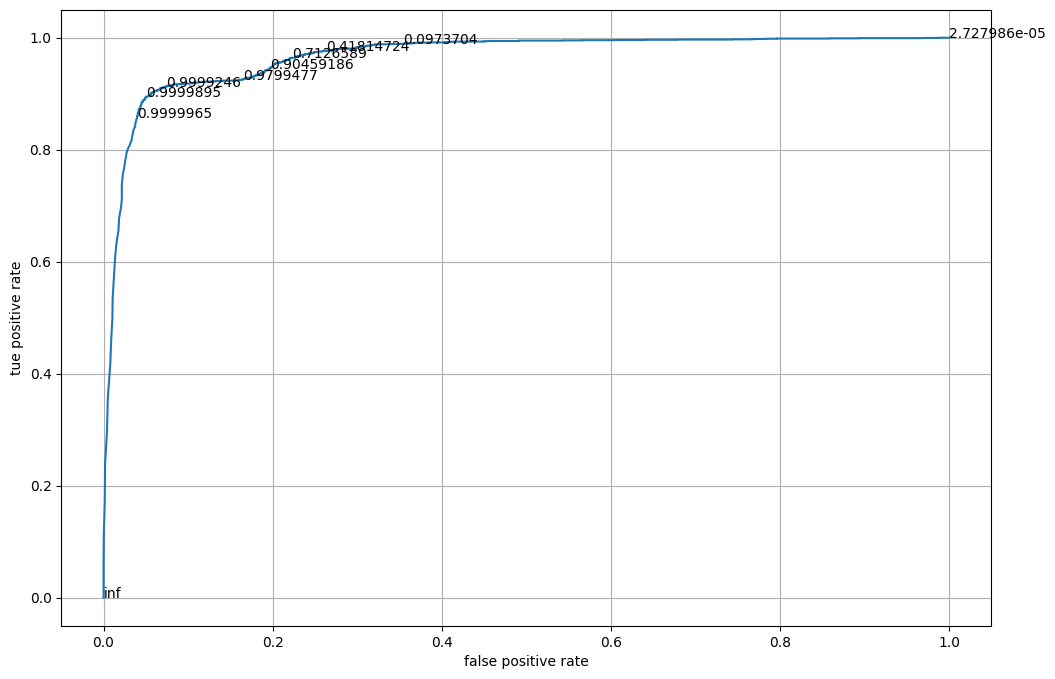

In [28]:
fp ,tp , thresholds = roc_curve(labels,y_pred)
plt.figure(figsize = (12,8))
plt.plot(fp,tp)
plt.xlabel('false positive rate')
plt.ylabel('tue positive rate')

skip = 60
for i in range(0 ,len(thresholds),skip):
    plt.text(fp[i],tp[i],thresholds[i])
plt.grid()

In [1]:
def pre(x):
    if(x<0.5):
        return str('P')
    else:return str('U')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


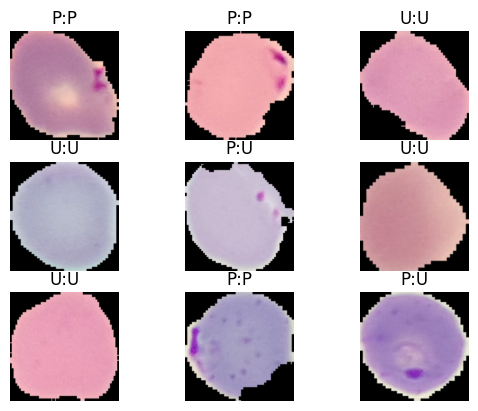

In [20]:
for i ,(image,label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(pre(label.numpy()[0]))+':'+str(pre(model.predict(image)[0][0])))
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


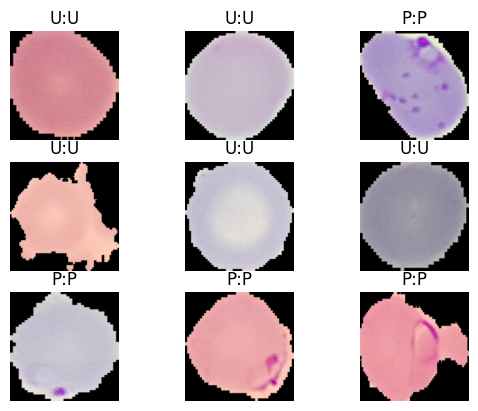

In [21]:
for i ,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(pre(label.numpy()[0]))+':'+str(pre(model.predict(image)[0][0])))
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


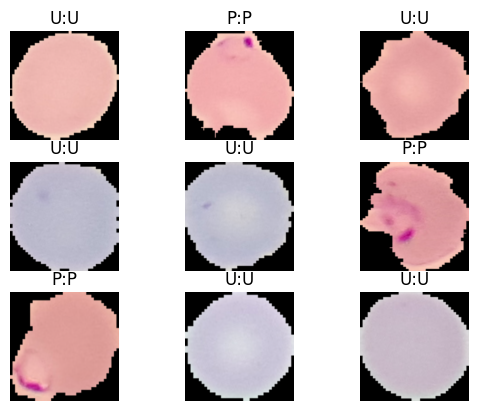

In [22]:
for i ,(image,label) in enumerate(val_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(pre(label.numpy()[0]))+':'+str(pre(model.predict(image)[0][0])))
    plt.axis('off')

### Functional API

In [23]:
seq_model = tf.keras.Sequential([InputLayer(shape=(IM_size,IM_size,3)),
                            Conv2D(filters=6,strides=1,kernel_size=3,padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2),
                            Conv2D(filters=16,strides=1,kernel_size=3,padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2)
                            ])
seq_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [24]:
func_input = Input(shape = (IM_size,IM_size,3) , name = "Input_Image")

x = Conv2D(filters=6,strides=1,kernel_size=3,padding='valid',activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,strides=1,kernel_size=3,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2,strides=2)(x)


feature_extractor_model = Model(func_input,output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [25]:
func_input = Input(shape = (IM_size,IM_size,3) , name = "Input_Image")

x = seq_model(func_input)

x = Flatten()(x)

x = Dense(100,activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(10,activation ='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation ='sigmoid')(x)

lenet_model = Model(func_input,func_output, name = "Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [26]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
                   loss = BinaryCrossentropy(),
             metrics = ['accuracy'])

In [27]:
history  =lenet_model.fit(train_dataset, validation_data= val_dataset , epochs=5,verbose =1)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 100s 188ms/step - accuracy: 0.7327 - loss: 0.5389 - val_accuracy: 0.9109 - val_loss: 0.2576
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 112s 217ms/step - accuracy: 0.9287 - loss: 0.2057 - val_accuracy: 0.9232 - val_loss: 0.2239
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 115s 222ms/step - accuracy: 0.9394 - loss: 0.1865 - val_accuracy: 0.9017 - val_loss: 0.3591
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 116s 225ms/step - accuracy: 0.9398 - loss: 0.1761 - val_accuracy: 0.9367 - val_loss: 0.2022
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 114s 221ms/step - accuracy: 0.9460 - loss: 0.1611 - val_accuracy: 0.9481 - val_loss: 0.1834


### Model Subclassing

In [28]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv1 = Conv2D(filters = filters,strides= strides,kernel_size = kernel_size,padding=padding,activation=activation)
        self.batch1 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=pool_size,strides=2*strides)
        
        self.conv2 = Conv2D(filters = filters*2,strides = strides,kernel_size=kernel_size,padding=padding,activation=activation)
        self.batch2 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=pool_size,strides=2*strides)
        
    def call(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.pool2(x)
        
        return x
feature_subclassed = FeatureExtractor(8,3,1,'valid','relu',2)

In [29]:
func_input = Input(shape = (IM_size,IM_size,3) , name = "Input_Image")

x = feature_subclassed(func_input)

x = Flatten()(x)

x = Dense(100,activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(10,activation ='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation ='sigmoid')(x)

lenet_model = Model(func_input,func_output, name = "Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [30]:
class Lenet(Model):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(Lenet, self).__init__()
        
        self.feature_extractor = FeatureExtractor(filters, kernel_size, strides, padding, activation, pool_size)
        self.flatten = Flatten()
        
        self.dense1 = Dense(100,activation ='relu')
        self.batch1 = BatchNormalization()
        
        self.dense2 = Dense(10,activation ='relu')
        self.batch2 = BatchNormalization()
        
        self.dense3 = Dense(1,activation ='sigmoid')
        
    def call(self,x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.batch1(x)
        
        x = self.dense2(x)
        x = self.batch2(x)
        
        x = self.dense3(x)
        
        return x
lenet_subclassed = Lenet(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)

# Test the model with a sample input
input_tensor = tf.zeros([1, 224, 224, 3])
lenet_subclassed(input_tensor)
# Print the model summary
lenet_subclassed.summary()

Model: "lenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ ?                           │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [31]:
class neuradense(Layer):
    def __init__(self,output_units,activation):
        super(neuradense,self).__init__()
        self.output_units = output_units
        self.activation = activation
    
    def build(self,input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1],self.output_units),initializer = 'random_normal',trainable = True)
        self.b = self.add_weight(shape = (self.output_units,),initializer = 'random_normal',trainable = True)
        
    def call(self,input_features):
        pre_output = tf.matmul(input_features,self.w) + self.b
        if(self.activation=='relu'):
            return tf.nn.relu(pre_output)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output
        

In [32]:
class NeuralearnDense(Layer):
    def __init__(self, output_units, activation):
        
        super(NeuralearnDense, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

    def call(self, input_features):

        pre_output = tf.matmul(input_features, self.w) + self.b

        if(self.activation == "relu"):
              return tf.nn.relu(pre_output)

        elif(self.activation == "sigmoid"):
              return tf.math.sigmoid(pre_output)

        else:
              return pre_output

### Model Training

In [33]:
custom_model = tf.keras.Sequential([InputLayer(shape=(IM_size,IM_size,3)),
                            Conv2D(filters=6,strides=1,kernel_size=3,padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2),
                            Conv2D(filters=16,strides=1,kernel_size=3,padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2,strides=2),
                            Flatten(),
                            neuradense(100,activation ='relu'),
                            BatchNormalization(),
                            neuradense(10,activation ='relu'),
                            BatchNormalization(),
                            NeuralearnDense(1,activation ='sigmoid')])
custom_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuradense (neuradense)              │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuradense_1 (neuradense)            │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense (NeuralearnDense)   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [34]:
custom_model.compile(optimizer = Adam(learning_rate=0.01),
                   loss = BinaryCrossentropy(),
             metrics = ['accuracy'])

In [35]:
history  =custom_model.fit(train_dataset, validation_data= val_dataset , epochs=5,verbose =1)

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 141s 268ms/step - accuracy: 0.8316 - loss: 0.3817 - val_accuracy: 0.9421 - val_loss: 0.2694
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 278ms/step - accuracy: 0.9341 - loss: 0.2053 - val_accuracy: 0.9338 - val_loss: 0.2298
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 278ms/step - accuracy: 0.9494 - loss: 0.1677 - val_accuracy: 0.5262 - val_loss: 0.5235
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 144s 279ms/step - accuracy: 0.9513 - loss: 0.1533 - val_accuracy: 0.9278 - val_loss: 0.3687
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 143s 276ms/step - accuracy: 0.9546 - loss: 0.1417 - val_accuracy: 0.9459 - val_loss: 0.2540
